In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from koala.example_graphs import generate_hex_square_oct,generate_honeycomb,generate_tri_non
from koala.graph_color import color_lattice
from koala.pointsets import generate_bluenoise
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.plotting import plot_lattice, peru_friendly_colour_scheme
import koala.plotting as pl

first we look at 4 examples of small systems

In [4]:
size = 2
honeycomb = generate_honeycomb(size * 2,True)

hex_squre_oct = generate_hex_square_oct(size)
hso_colouring = color_lattice(hex_squre_oct)

three_nine = generate_tri_non([size,size*2], True)

points = generate_bluenoise(30,size*2,size*2)
amorphous = generate_lattice(points)
am_colouring = color_lattice(amorphous)

lattice_systems = [
    honeycomb[0],
    hex_squre_oct,
    three_nine[0],
    amorphous
]

colourings = [
    honeycomb[1],
    hso_colouring,
    three_nine[1],
    am_colouring
]

names = ['Honeycomb', 'Hex_squre_oct', 'Three_nine', 'Amorphous']

J_vals = np.array([1,1,1])

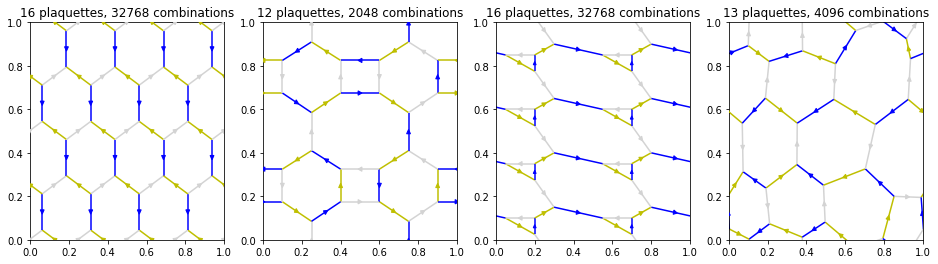

In [5]:
colour_scheme = peru_friendly_colour_scheme(3)

n_systems = len(lattice_systems)
plot_sides = int(np.ceil(n_systems/2))

fig, axes = plt.subplots(ncols = 4, figsize = (16,4))

for n,lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    pl.plot_edges(lattice, ax= ax, labels=colourings[n], color_scheme= colour_scheme, directions = 1)
    ax.set_title(f'{lattice.n_plaquettes} plaquettes, {2**(lattice.n_plaquettes-1)} combinations')


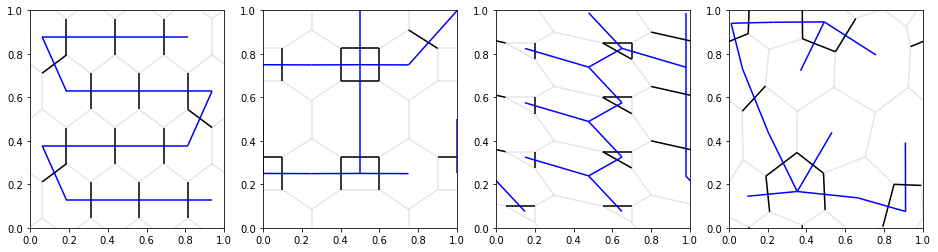

In [6]:
from koala import graph_utils
from matplotlib.collections import LineCollection

def dual_minimum_spanning_tree(lattice):
    dual = graph_utils.make_dual(lattice)
    edges = graph_utils.minimum_spanning_tree(dual)
    return edges

spanning_trees = [dual_minimum_spanning_tree(lat) for lat in lattice_systems]
spanning_trees = [graph_utils.plaquette_spanning_tree(lat) for lat in lattice_systems]

fig, axes = plt.subplots(ncols = 4, figsize = (16,4))

for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    edges_in_tree = spanning_trees[n]
    
    pl.plot_edges(lattice, ax= ax, alpha = 0.1)
    pl.plot_edges(lattice, ax= ax, subset = spanning_trees[n])
    pl.plot_dual(lattice, spanning_trees[n], color = 'blue', ax = ax)



In [7]:
from koala.lattice import Lattice

def construct_Ajk(lattice: Lattice, edge_colouring: np.ndarray, ujk: np.ndarray, J_values: np.ndarray):
    """construct the A matrix that the hamiltonian uses

    :param lattice: system to construct the matrix on
    :type lattice: Lattice
    :param edge_colouring: colouring for the edges must be a set of ±1 values
    :type edge_colouring: np.ndarray
    :param ujk: bond signs
    :type ujk: np.ndarray
    :param J_values: j values
    :type J_values: np.ndarray
    :return: the A matrix
    :rtype: np.ndarray
    """
    edge_type_list = J_values[edge_colouring]
    bond_values = 2*edge_type_list*ujk

    ham = np.zeros((lattice.n_vertices, lattice.n_vertices), dtype = float)
    ham[lattice.edges.indices[:,1], lattice.edges.indices[:,0]] = bond_values
    ham[lattice.edges.indices[:,0], lattice.edges.indices[:,1]] = -bond_values

    return ham

def find_ground_state_energy(lattice: Lattice, edge_colouring: np.ndarray, ujk: np.ndarray, J_values: np.ndarray):
    ham = construct_Ajk(lattice,edge_colouring,ujk,J_values)
    energies = np.linalg.eigvalsh(1j*ham)
    energy = -np.sum(np.abs(energies))/4
    return energy

-25.057193434767473
-16.492422502470646
-24.227942796199013
-19.62512054282824


Text(0.5, 0.98, 'Ujk = +1 states')

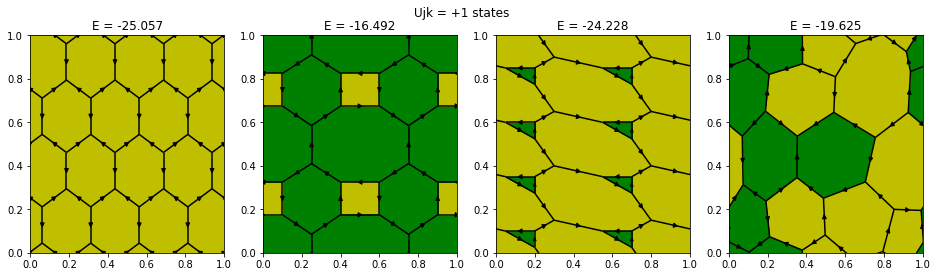

In [8]:
from koala.flux_finder import fluxes_to_labels, fluxes_from_bonds

# now set default ujk values for all of them
ujk_values = []
for lattice in lattice_systems:
    ujk = np.ones(lattice.n_edges)
    ujk_values.append(ujk)

# and plot the fluxes for all the graphs
fluxes = []
for n, lattice in enumerate(lattice_systems):
    fluxes.append( fluxes_from_bonds(lattice,ujk_values[n]))

fig, axes = plt.subplots(ncols = 4, figsize = (16,4))

for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    ax.set(title = names[n])
    pl.plot_edges(lattice, ax=ax, directions = 1)
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes[n]), ax= ax,color_scheme=['y', 'g'])
    
    energy = find_ground_state_energy(lattice, colourings[n], np.ones(lattice.n_edges), J_vals)
    print(energy)
    
    energy = find_ground_state_energy(lattice, colourings[n], ujk_values[n], J_vals)
    ax.set(title = f"E = {energy:.3f}")
fig.suptitle('Ujk = +1 states')

In [9]:
def int_to_u_values(num, ujk_base, spanning_tree):

    width = len(spanning_tree)
    string_version = np.binary_repr(num,width = width)
    flip_key = np.array([int(x) for x in string_version])
    index_flips = np.where(flip_key)[0]
    edges_to_flip = spanning_tree[index_flips]
    
    ujk_out = ujk_base.copy()
    ujk_out[edges_to_flip] = -1
    return ujk_out

def serial_enumerator():
    all_energies = []
    for n,system in enumerate(lattice_systems):
        e_vals = np.zeros(2**len(spanning_trees[n]))
        
        print(f'doing system {n}')
        for a in range(2**len(spanning_trees[n])):

            ujk_for_run = int_to_u_values(a, ujk_values[n], spanning_trees[n])
            energy = find_ground_state_energy(system, colourings[n],ujk_for_run,J_vals)
            e_vals[a] = energy
        all_energies.append(e_vals)
    return all_energies
  
def int_to_energy(t):
    i,n = t
    ujk_for_run = int_to_u_values(i, ujk_values[n], spanning_trees[n])
    energy = find_ground_state_energy(system, colourings[n],ujk_for_run,J_vals)
    
    
from itertools import repeat
def parallel_enumerator():
    from multiprocessing import Pool

    all_energies = [None for _ in lattice_systems]
    for n,system in enumerate(lattice_systems):
        N = 2**len(spanning_trees[n])
        with Pool() as p:
            all_energies[n] = p.map(int_to_energy, zip(range(N),repeat(n)), chunksize = N // 8)
    return all_energies
 
all_energies = serial_enumerator()

doing system 0
doing system 1
doing system 2
doing system 3


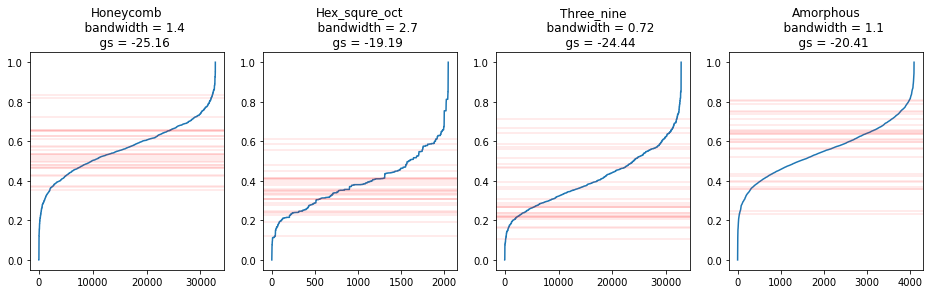

In [10]:
fig, axes = plt.subplots(ncols = 4, figsize = (16,4))

def plot_energies(ax, n):
    Es = sorted(all_energies[n])
    gs, hs = min(Es), max(Es)
    bandwidth = hs - gs
    ax.plot((Es - gs) / bandwidth)
    return gs, hs, bandwidth
    

for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    gs, hs, bandwidth = plot_energies(ax, n)

    ax.set(title = f"""{names[n]}
    bandwidth = {bandwidth:.2}
    gs = {gs:.2f}""")
    
    random_energies = np.array([find_ground_state_energy(lattice_systems[n], colourings[n], np.random.choice([1,-1], lattice_systems[n].n_edges),J_vals)
                        for _ in range(30)])
    for e in random_energies: ax.axhline((e - gs) / bandwidth, alpha = 0.1, color = 'r')

    

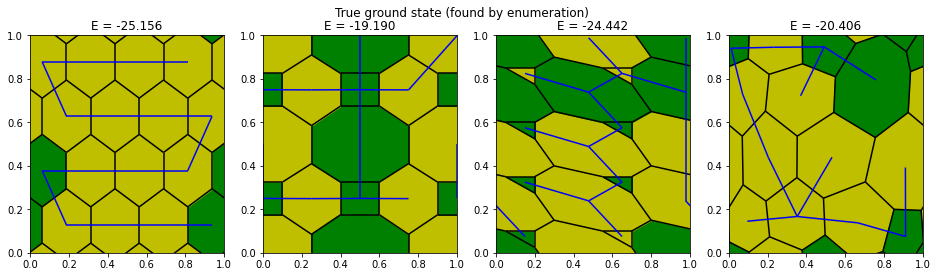

In [11]:
winning_indices = np.array([np.argmin(en) for en in all_energies])
losing_indices = np.array([np.argmax(en) for en in all_energies]) 

winning_ujks = []
losing_ujks = []
winning_energies = []
losing_energies = []
fluxes = []
for n, index  in enumerate(winning_indices.flatten()):
    winning_ujks.append( int_to_u_values(index,ujk_values[n], spanning_trees[n]) )
    energy = find_ground_state_energy(lattice_systems[n], colourings[n], winning_ujks[n], J_vals)
    winning_energies.append(energy)
    
    losing_ujks.append( int_to_u_values(losing_indices.flatten()[n],ujk_values[n], spanning_trees[n]) )
    energy = find_ground_state_energy(lattice_systems[n], colourings[n], losing_ujks[n], J_vals)
    losing_energies.append(energy)
    
    fluxes.append( fluxes_from_bonds(lattice_systems[n], winning_ujks[n]))    
    

fig, axes = plt.subplots(ncols = 4, figsize = (16,4))

for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    pl.plot_edges(lattice, ax=ax)
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes[n]), ax= ax,color_scheme=['y', 'g'])
    pl.plot_dual(lattice, spanning_trees[n], color = 'blue', ax = ax)
    ax.set(title = f"E = {winning_energies[n]:.3f}")
    
fig.suptitle('True ground state (found by enumeration)');

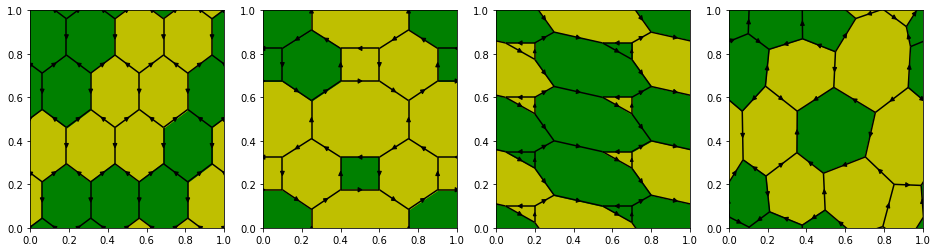

In [12]:
fig, axes = plt.subplots(ncols = 4, figsize = (16,4))
ujks = [np.random.choice([-1,1], size = l.n_edges) for l in lattice_systems]

for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    pl.plot_edges(lattice, ax=ax, directions = 1)
    fluxes = fluxes_from_bonds(lattice, ujks[n])
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes), ax= ax,color_scheme=['y', 'g'])

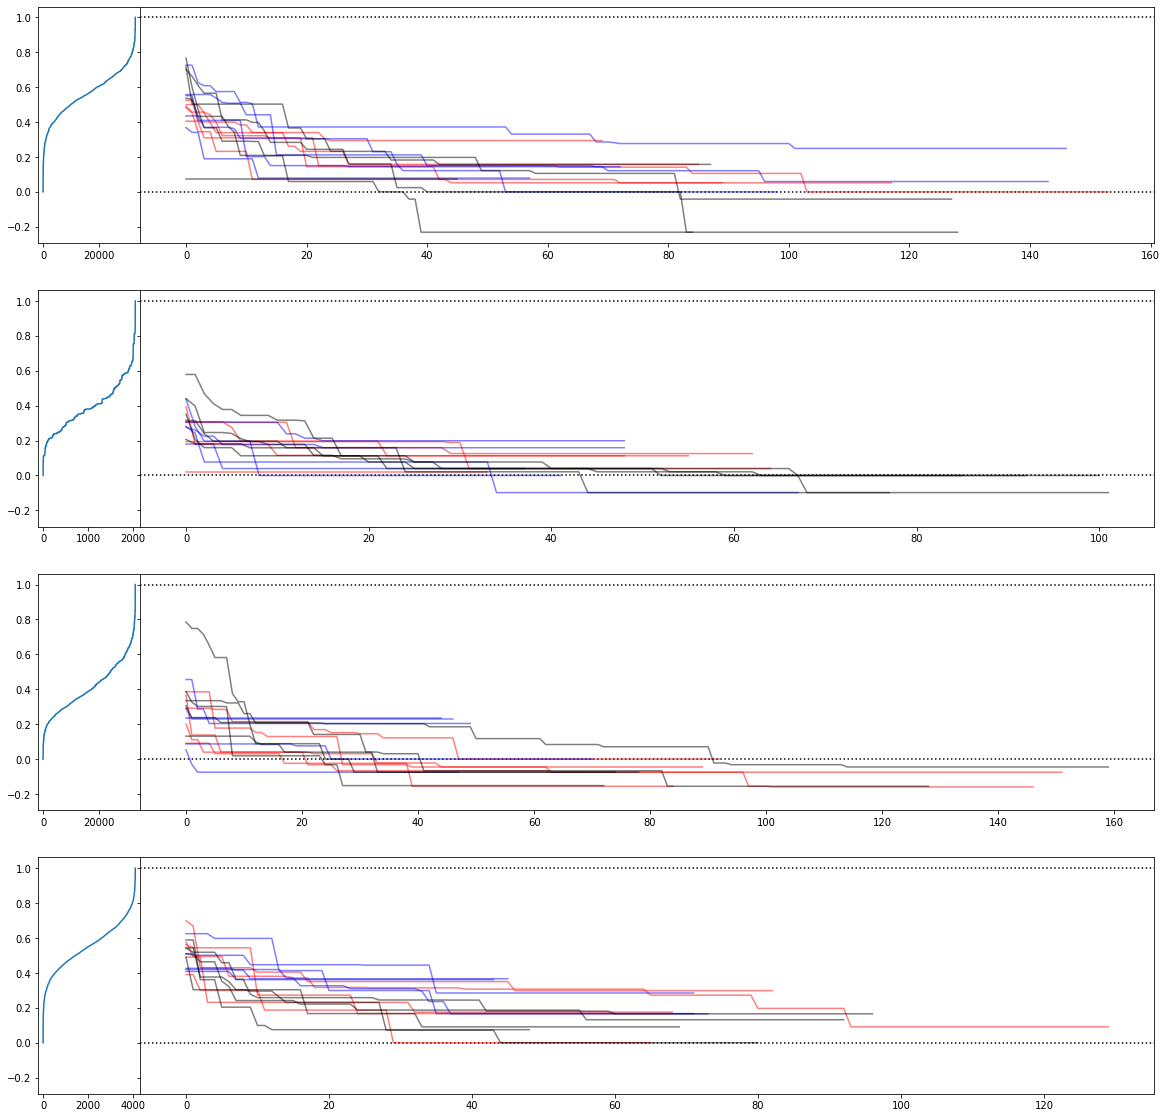

In [13]:
from koala.lattice import Lattice
from koala.flux_finder.pathfinding import path_between_plaquettes

def flip_edges(lattice, ujk, hamiltonian, edge_indices):
    idx = lattice.edges.indices[edge_indices]
    ujk[edge_indices] *= -1
    hamiltonian[idx[:,1], idx[:,0]] *= -1
    hamiltonian[idx[:,0], idx[:,1]] *= -1

def fermion_ground_state_energy(ham):
    energies = np.linalg.eigvalsh(1j*ham)
    energy = -np.sum(np.abs(energies))/4
    return energy

def random_edge(lattice): 
    return np.random.choice(spanning_trees[n], size = 2)

def random_spanning_tree_edge(spanning_tree):
    def f(lattice): return np.random.choice(spanning_tree, size = 1)
    return f

def random_plaquette_pair(lattice):
    a,b = np.random.choice(np.arange(lattice.n_plaquettes), size = 2, replace = False)
    plaquettes, edges_to_flip = path_between_plaquettes(lattice, a, b)
    return edges_to_flip
    

def descent(lattice, hamiltonian, ujk, max_iterations, move_function = random_edge):
    "MCMC with beta = 0, just try to go down in energy"
    ujk = ujk.copy()
    energy = fermion_ground_state_energy(hamiltonian)
    energies = np.nan*np.zeros(max_iterations, dtype = float)
    stuck_for = 0
    
    for i in range(max_iterations):
        random_edges = move_function(lattice)
        flip_edges(lattice, ujk, hamiltonian, random_edges)
        new_energy = fermion_ground_state_energy(hamiltonian)
        delta = new_energy - energy
        if delta > 0: # if this move raised the energy
            flip_edges(lattice, ujk, hamiltonian, random_edges) # undo the move
            stuck_for += 1
        else:
            energy = new_energy #stick with the move
            stuck_for = 0
        
        if stuck_for > len(spanning_trees[n]) * 3: break
        energies[i] = energy
    return ujk, energies[:i]

fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (20,10*plot_sides), 
                         sharey = 'all', gridspec_kw = dict(width_ratios = (1,10), wspace = 0))

out_ujks = [[] for _ in lattice_systems]
for n, lattice in enumerate(lattice_systems):
    ax1, ax2 = axes[n]
    gs, hs, bandwidth = plot_energies(ax1, n)
    ax2.axhline(0, linestyle = 'dotted', color = 'k')
    ax2.axhline(1, linestyle = 'dotted', color = 'k')
    
    for color, move_function in zip(
                ['r', 'b', 'k'],
                [random_edge, random_spanning_tree_edge(spanning_trees[n]),random_plaquette_pair],
                                ):
        for i in range(5):
            ujk = np.random.choice([-1,1], size = lattice.n_edges)
            hamiltonian = construct_Ajk(lattice, colourings[n], ujk, J_vals)
            out_ujk, energies = descent(lattice, hamiltonian, ujk, max_iterations = 5000, move_function = move_function)
            ax2.plot((energies - gs) / bandwidth, color = color, alpha = 0.5)
            out_ujks[n].append([energies[-1], out_ujk])

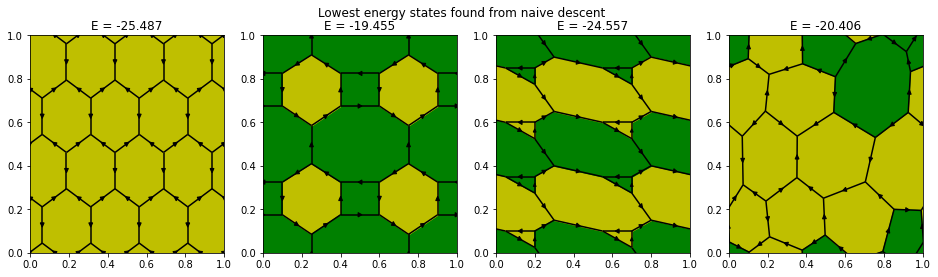

In [14]:
fig, axes = plt.subplots(ncols = 4, figsize = (16,4))

for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    e, ujk = min(out_ujks[n], key = lambda x : x[0])
    ax.set(title = f"E = {e:.3f}")

    fluxes = fluxes_from_bonds(lattice, ujk)
    pl.plot_edges(lattice, ax=ax, directions = 1)
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes), ax= ax,color_scheme=['y', 'g'])
fig.suptitle(f"Lowest energy states found from naive descent");

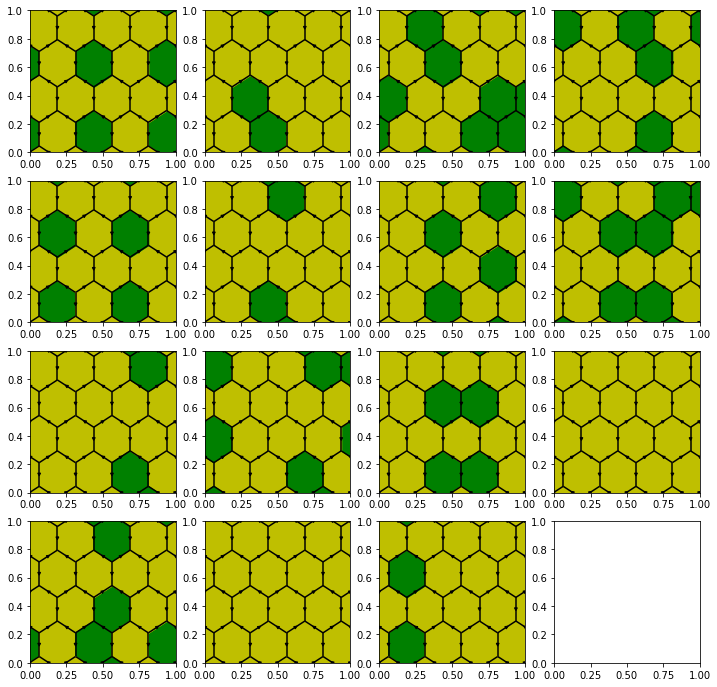

In [15]:
i = 0
lattice = lattice_systems[i]
N = len(out_ujks[i])
nrows, ncols = 4,4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (ncols*3,nrows*3))

for n in range(N):
    ax = axes.flatten()[n]
    e, ujk = out_ujks[i][n]
    fluxes = fluxes_from_bonds(lattice, ujk)
    pl.plot_edges(lattice, ax=ax, directions = 1)
    pl.plot_plaquettes(lattice, labels = fluxes_to_labels(fluxes), ax = ax,color_scheme=['y', 'g'])

Lattice(16 vertices, 21 edges)

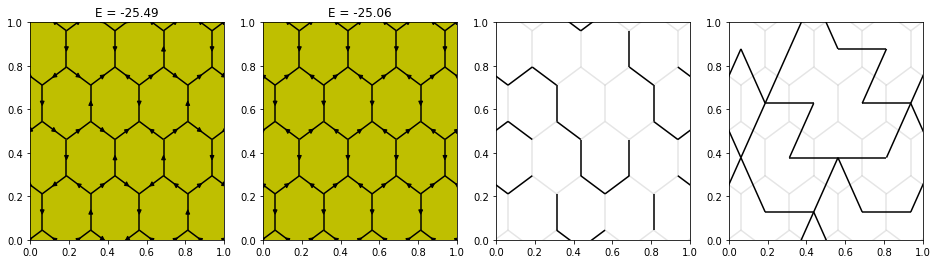

In [16]:
J_vals = np.array([1,1,1])
lattice, coloring = generate_honeycomb(4,True)

def ujk_to_labels(ujk): return fluxes_to_labels(fluxes_from_bonds(lattice, ujk))

ujk1 = np.array([ 1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1,
        1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1])

ujk2 = np.abs(ujk1)
subset = np.where(ujk1 != ujk2)

fig, axes = plt.subplots(ncols = 4, figsize = (16,4))


for ax, ujk in zip(axes[:2], [ujk1, ujk2]):
    e = find_ground_state_energy(lattice, coloring, ujk, J_vals)
    ax.set(title = f'E = {e:.2f}')
    pl.plot_edges(lattice, ax=ax, directions = ujk)
    pl.plot_plaquettes(lattice, labels = ujk_to_labels(ujk), ax = ax,color_scheme=['y', 'g'])
    
pl.plot_edges(lattice, ax = axes[2], alpha = 0.1)
pl.plot_edges(lattice, subset = subset, ax = axes[2])

pl.plot_edges(lattice, ax = axes[3], alpha = 0.1)
pl.plot_dual(lattice, subset = subset, ax = axes[3])

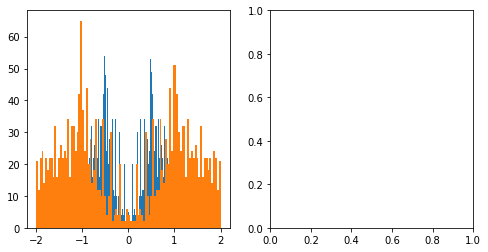

In [17]:
from koala import hamiltonian as h
from koala import example_graphs as eg

def honecomb_energies(Js):
    honeycomb, coloring = generate_honeycomb(size * 2,True)
    # ujk = np.random.choice([-1,1], size = lattice.n_edges)
    ujk = np.ones(lattice.n_edges)
    hamiltonian = construct_Ajk(lattice, colourings[n], ujk, Js)
    energy = fermion_ground_state_energy(hamiltonian)
    return 

lattice, coloring = eg.generate_honeycomb(30, True)
ujk = np.ones(lattice.n_edges)
Js = np.array([1, .5, .5])


maj_ham = h.generate_majorana_hamiltonian(lattice, coloring, ujk, Js)

l = h.bisect_lattice(lattice, coloring, 0)
ham_bisected = h.generate_majorana_hamiltonian(l, coloring, ujk, Js)
ham_fermionic = h.majorana_to_fermion_ham(ham_bisected)


maj_energies = np.linalg.eigvalsh(maj_ham)
ferm_energies = np.linalg.eigvalsh(ham_fermionic)

f, axes = plt.subplots(ncols = 2, figsize = (8, 4))
axes[0].hist(maj_energies, bins = 100);
axes[0].hist(ferm_energies, bins = 100);

In [19]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

from matplotlib.collections import LineCollection
def plot_triangle(ax):
    points = np.array([[0,0], [np.cos(np.pi/3),np.sin(np.pi/3)], [1,0]])
    lines = [[points[i], points[(i+1)%3]] for i in range(3)]
    sub_triangle_points = [(points[i] + points[(i+1)%3])/2 for i in range(3)]
    sub_triangle_lines = [[sub_triangle_points[i], sub_triangle_points[(i+1)%3]] for i in range(3)]
    
    ax.add_collection(LineCollection(sub_triangle_lines, color = 'k', linestyle = 'dotted'))
    ax.add_collection(LineCollection(lines, color = 'k'))

def get_triangular_sampling_points(samples = 10):
    # Create triangulation.
    # Start with the unit square
    Jx = np.linspace(0,0.5,samples)
    Jy = np.linspace(0,0.5,samples)
    grid_spacing = 1 / samples

    points = np.array([(x,y) for y in Jy for x in Jx])

    xs,ys = points.T
    zs = 1 - xs - ys
    
    shape = (zs - ys >= -grid_spacing/2) & (ys - xs >= -grid_spacing/2)
    points = points[shape]
    points = np.concatenate([points, [[1/3,1/3],]]) #add the center point because it sometimes gets cut off
    
    xs,ys = points.T
    zs = 1 - xs - ys
    triple_points = np.array([xs, ys, zs]).T
    
    
    def rotation(t): return np.array([[np.cos(t), -np.sin(t)],[np.sin(t), np.cos(t)]])
    reflection = np.array([[0, 1],[1, 0]])
    centerp =  np.array([0.5,np.tan(np.pi/6)/2])
    skew = np.array([[1, np.cos(np.pi/3)],
                          [0, np.sin(np.pi/3)]])
    
    triangulations = []
    for reflect in [False,True]:
        for i in range(3):
            #reflect in the diagonal 
            lpoints = points[:, ::-1].copy() if reflect else points.copy()
            
            # Transform the right triangle into an equilateral one for plotting
            lpoints = np.einsum('ij,kj -> ki', skew, lpoints)
            
            # Rotate about the center point
            lpoints -= centerp
            t = -2*np.pi/3 * i
            lpoints = np.einsum('ij,kj -> ki', rotation(t), lpoints)
            lpoints += centerp
            
            #save this triangulation
            triangulations.append(mtri.Triangulation(*lpoints.T))
    
    return triple_points, triangulations

def plot_tri(ax, data, triangulations):
    vmin, vmax = np.min(data), np.max(data)
    
    for t in triangulations: 
        ax.tricontourf(t, data, vmin = vmin, vmax = vmax)
        # ax.triplot(t, 'ko-', markersize = 1)

def fake_data(points): return np.linalg.norm(points, axis = -1)



# sampling_points, triangulation = get_triangular_sampling_points(samples = 6)
# print(len(sampling_points))

# lattice, coloring = eg.generate_honeycomb(30, True)
# ujk = np.ones(lattice.n_edges)
# shared_objects = dict(lattice = lattice, coloring = coloring, ujk = ujk)

# def f(shared_objects, Js):
#     return honeycomb_gap(size = 2, Js=Js.squeeze(), e_threshold = 0.1, **shared_objects)

# from mpire import WorkerPool
# # gaps = [f(Js) for Js in sampling_points]
# with WorkerPool(n_jobs=5, shared_objects = shared_objects) as pool: 
#     gaps = pool.map(f, sampling_points, progress_bar = True)


# f, ax = plt.subplots()
# plot_triangle(ax)
# ax.triplot(triangulation, 'ko-', markersize = 1)
# ax.tricontourf(triangulation, gaps)

In [21]:
# import matplotlib.pyplot as plt
# import matplotlib.tri as mtri
# import numpy as np
# from mpire import WorkerPool

# def get_non_symmetric_triangular_sampling_points(samples = 10):
#     # Create triangulation.
#     # Start with the unit square
#     Jx = np.linspace(0,0.5,samples)
#     Jy = np.linspace(0,0.5,samples)
#     grid_spacing = 0.5 / samples

#     points = np.array([(x,y) for y in Jy for x in Jx])

#     # Get rid of the uneccessary half of the square giving a right triangle
#     xs,ys = points.T
#     w = np.where(xs + ys <= 1)
#     points = points[w]
#     xs,ys = points.T
#     zs = 1 - xs - ys
#     triple_points = np.array([xs, ys, zs]).T
    
#     # Transform the right triangle into an equilateral one for plotting
#     theta = np.pi/3
#     T = np.array([[1, np.cos(theta)],
#                   [0, np.sin(theta)]])

#     tpoints = np.einsum('ij,kj -> ki', T, points)
#     triangulation = mtri.Triangulation(*tpoints.T)
    
#     return triple_points, triangulation

# def honeycomb_gap(Js, e_threshold, lattice, coloring, ujk):
#     maj_ham = h.generate_majorana_hamiltonian(lattice, coloring, ujk, Js)
#     #maj_energies = np.linalg.eigvalsh(maj_ham)
#     maj_energies = scipy.linalg.eigvalsh(maj_ham, subset_by_value = (-e_threshold,e_threshold))
#     return np.count_nonzero(np.abs(maj_energies) < e_threshold)

# sampling_points, triangulation = get_non_symmetric_triangular_sampling_points(samples = 20)

# lattice, coloring = eg.generate_honeycomb(15, True)
# ujk = np.ones(lattice.n_edges)
# shared_objects = dict(lattice = lattice, coloring = coloring, ujk = ujk)

# e_threshold = 0.1

# def f(shared_objects, Js):
#     return np.array([
#         honeycomb_gap(Js=J, e_threshold = e_threshold, **shared_objects)
#                      for J in Js])

# # %time gaps = np.concatenate([f(shared_objects, [Js,]) for Js in sampling_points])
# print(f'{len(sampling_points)} points to do')
# with WorkerPool(n_jobs=6, shared_objects = shared_objects) as pool: 
#     %time gaps = pool.map(f, sampling_points, progress_bar = True)


# f, ax = plt.subplots()
# ax.set(title = f'# states within {e_threshold:.2f} of 0')
# plot_triangle(ax)
# ax.triplot(triangulation, 'ko-', markersize = 1)
# ax.tricontourf(triangulation, gaps)

In [28]:
!pip install mpire

Starting computation over 141 points with 10 parallel procesess.


  0%|          | 0/40 [00:00<?, ?it/s]

That tooks 5.03 seconds or 357ms per sample point


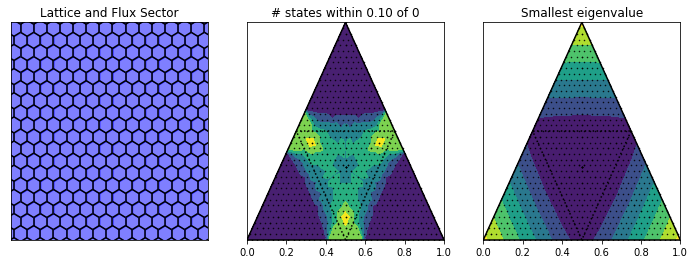

In [59]:
import scipy
from matplotlib.colors import to_rgba
from time import time
from mpire import WorkerPool

def gap(Js, e_threshold, e_range, lattice, coloring, ujk):
    maj_ham = h.generate_majorana_hamiltonian(lattice, coloring, ujk, Js)
    #maj_energies = np.linalg.eigvalsh(maj_ham)
    maj_energies = scipy.linalg.eigvalsh(maj_ham, subset_by_value = (-e_range,e_range))
    return np.count_nonzero(np.abs(maj_energies) < e_threshold), min(np.abs(maj_energies))


def compute_phase_diagram(sampling_points, function, extra_args, n_jobs = 6):
    print(f"Starting computation over {len(sampling_points)} points with {n_jobs} parallel procesess.")
    def computation(extra_args, Js):
        return np.array([function(J, **extra_args) for J in Js])

    t0 = time()
    with WorkerPool(n_jobs = n_jobs, shared_objects = extra_args) as pool: 
        data = pool.map(computation, sampling_points, progress_bar = True).T
    dt = time() - t0
    print(f'That tooks {dt:.2f} seconds or {dt/len(sampling_points)*1000*n_jobs:.0f}ms per sample point')

    return data

def plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps, axes = None):
    if axes is None: f, axes = plt.subplots(ncols = 3, figsize = (12,4))

    ax = axes[0]
    ax.set(title = f'Lattice and Flux Sector', xticks = [], yticks = [])
    pl.plot_edges(lattice, ax = ax)

    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes_from_bonds(lattice, ujk)),
                       ax=ax,color_scheme=[to_rgba('blue',0.5), to_rgba('orange', 0.5)])

    ax = axes[1]
    ax.set(title = f'# states within {e_threshold:.2f} of 0')
    plot_triangle(ax)
    ax.triplot(triangulation, 'ko-', markersize = 1)
    ax.tricontourf(triangulation, number_in_range)

    ax = axes[2]
    ax.set(title = f'Smallest eigenvalue')
    plot_triangle(ax)
    ax.triplot(triangulation, 'ko-', markersize = 1)
    ax.tricontourf(triangulation, gaps)
    
def plot_tri(ax, data, triangulations):
    # ax.axis('off')
    ax.axes.get_yaxis().set_visible(False)
    vmin, vmax = np.min(data), np.max(data)
    
    for t in triangulations: 
        ax.triplot(t, 'k.', markersize = 1)
        ax.tricontourf(t, data, vmin = vmin, vmax = vmax, zorder = -1)
        
def plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps, axes = None):
    if axes is None: f, axes = plt.subplots(ncols = 3, figsize = (12,4))

    ax = axes[0]
    ax.set(title = f'Lattice and Flux Sector', xticks = [], yticks = [])
    pl.plot_edges(lattice, ax = ax)

    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes_from_bonds(lattice, ujk)),
                       ax=ax,color_scheme=[to_rgba('blue',0.5), to_rgba('orange', 0.5)])

    ax = axes[1]
    ax.set(title = f'# states within {e_threshold:.2f} of 0')
    plot_triangle(ax)
    plot_tri(ax, number_in_range, triangulations)

    ax = axes[2]
    ax.set(title = f'Smallest eigenvalue')
    plot_triangle(ax)
    plot_tri(ax, gaps, triangulations)
    
symmetric = True
if "results" not in globals(): results = {}

if symmetric: sampling_points, triangulation = get_triangular_sampling_points(samples = 20)
else: sampling_points, triangulation = get_non_symmetric_triangular_sampling_points(samples = 20)

lattice, coloring = eg.generate_honeycomb(15, True)
ujk = np.ones(lattice.n_edges)

extra_args = dict(lattice = lattice,
                  coloring = coloring,
                  ujk = ujk,
                  e_threshold = 0.1,
                  e_range = 0.5)

number_in_range, gaps = compute_phase_diagram(sampling_points, gap, extra_args, n_jobs = 10)

if symmetric: plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps)
else:plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps)

results["Honeycomb GS"] = [lattice, ujk, triangulation, number_in_range, gaps]

Starting computation over 141 points with 10 parallel procesess.


  0%|          | 0/40 [00:00<?, ?it/s]

That tooks 5.31 seconds or 377ms per sample point


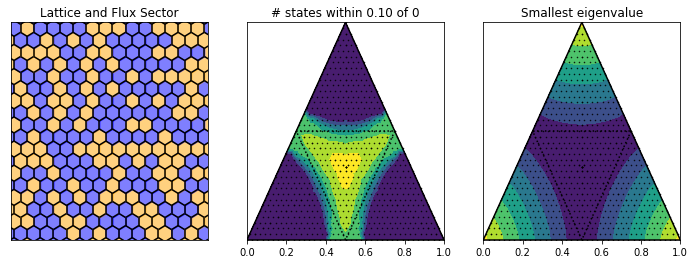

In [56]:
if symmetric: sampling_points, triangulation = get_triangular_sampling_points(samples = 20)
else: sampling_points, triangulation = get_non_symmetric_triangular_sampling_points(samples = 20)

lattice, coloring = eg.generate_honeycomb(15, True)
ujk = np.random.choice([1,-1], lattice.n_edges)

extra_args = dict(lattice = lattice,
                  coloring = coloring,
                  ujk = ujk,
                  e_threshold = 0.1,
                  e_range = 0.5)

number_in_range, gaps = compute_phase_diagram(sampling_points, gap, extra_args, n_jobs = 10)

if symmetric: plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps)
else:plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps)

results["Honeycomb Random Flux Sector"] = [lattice, ujk, triangulation, number_in_range, gaps]

Starting computation over 141 points with 10 parallel procesess.


  0%|          | 0/40 [00:00<?, ?it/s]

That tooks 5.50 seconds or 390ms per sample point


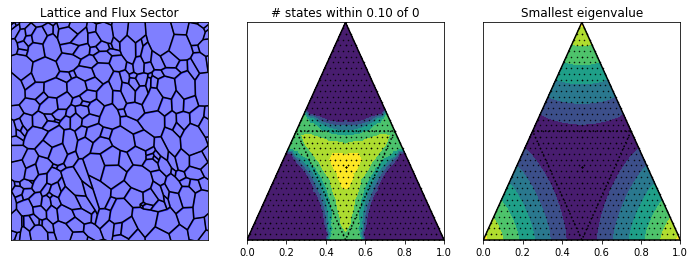

In [57]:
from koala import pointsets, voronization, graph_color, flux_finder

points = pointsets.generate_random(15**2)
lattice = voronization.generate_lattice(points)
coloring = graph_color.color_lattice(lattice)
ujk = flux_finder.find_flux_sector(lattice)

if symmetric: sampling_points, triangulation = get_triangular_sampling_points(samples = 20)
else: sampling_points, triangulation = get_non_symmetric_triangular_sampling_points(samples = 20)

number_in_range, gaps = compute_phase_diagram(sampling_points, gap, extra_args, n_jobs = 10)

if symmetric: plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps)
else:plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps)

results["Amorphous (almost) Zero Flux Sector"] = [lattice, ujk, triangulation, number_in_range, gaps]

Starting computation over 141 points with 10 parallel procesess.


  0%|          | 0/40 [00:00<?, ?it/s]

That tooks 3.84 seconds or 272ms per sample point


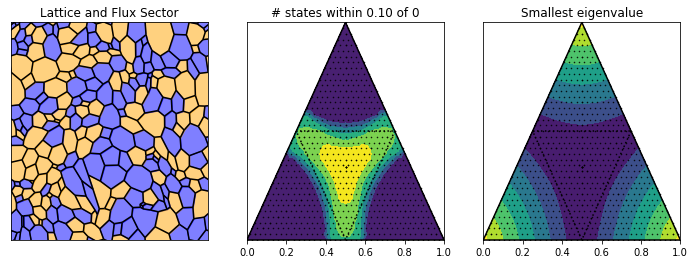

In [58]:
from koala import pointsets, voronization, graph_color

if "Amorphous (almost) Zero Flux Sector" in results:
    lattice = results["Amorphous (almost) Zero Flux Sector"][0]
else:
    points = pointsets.generate_random(15**2)
    lattice = voronization.generate_lattice(points)

coloring = graph_color.color_lattice(lattice)
ujk = np.ones(lattice.n_edges)

if symmetric: sampling_points, triangulation = get_triangular_sampling_points(samples = 20)
else: sampling_points, triangulation = get_non_symmetric_triangular_sampling_points(samples = 20)

extra_args = dict(lattice = lattice,
                  coloring = coloring,
                  ujk = ujk,
                  e_threshold = 0.1,
                  e_range = 0.5)

number_in_range, gaps = compute_phase_diagram(sampling_points, gap, extra_args, n_jobs = 10)

if symmetric: plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps)
else:plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps)

results["Amorphous Random Flux Sector"] = [lattice, ujk, triangulation, number_in_range, gaps]

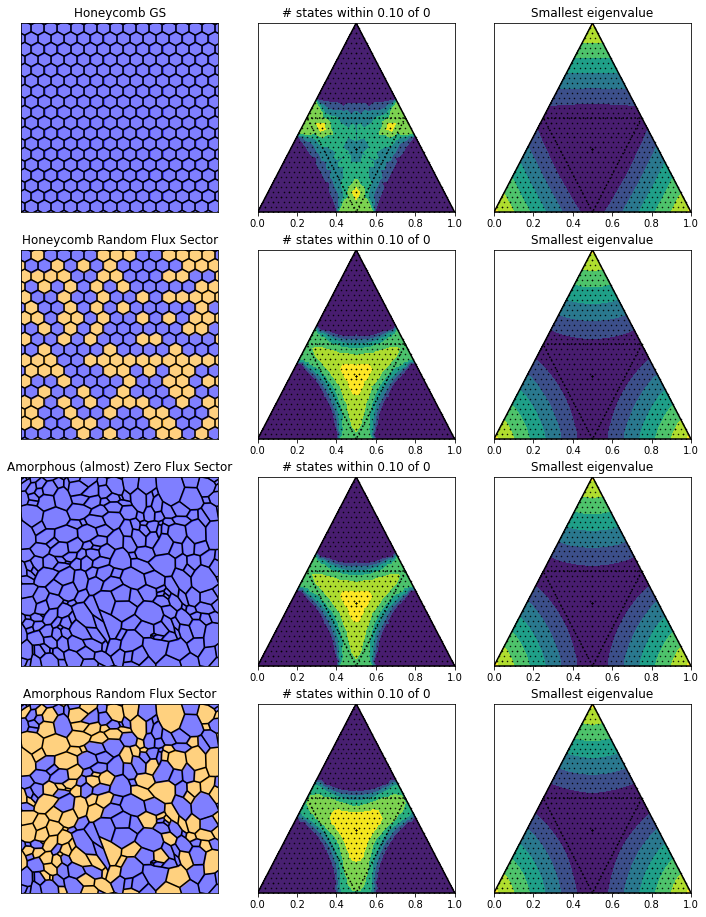

In [62]:
def plot_multiple_phase_diagram(results):
    f, rows = plt.subplots(ncols = 3, nrows = len(results), squeeze = False, figsize = (12,4*len(results)))
    for (name, res), axes in zip(results.items(), rows):
        lattice, ujk, triangulation, number_in_range, gaps = res
        if symmetric: plot_phase_diagram_symmetric(lattice, ujk, triangulation, number_in_range, gaps, axes = axes)
        else: plot_phase_diagram(lattice, ujk, triangulation, number_in_range, gaps, axes = axes)
        axes[0].set(title = name)
        
plot_multiple_phase_diagram(results)

In [33]:
import scipy
e_threshold = 0.1
%time lattice, coloring = eg.generate_honeycomb(30, True)
ujk = np.ones(lattice.n_edges)
%time maj_ham = h.generate_majorana_hamiltonian(lattice, coloring, ujk, Js)
%time maj_energies = np.linalg.eigvalsh(maj_ham)
%time maj_energies = scipy.linalg.eigvalsh(maj_ham, subset_by_value = (-e_threshold,e_threshold))

CPU times: user 69.1 ms, sys: 2.31 ms, total: 71.4 ms
Wall time: 72 ms
CPU times: user 38 ms, sys: 33 ms, total: 70.9 ms
Wall time: 71.4 ms
CPU times: user 4.07 s, sys: 35.4 ms, total: 4.1 s
Wall time: 4.12 s
CPU times: user 2.9 s, sys: 52.6 ms, total: 2.95 s
Wall time: 2.96 s


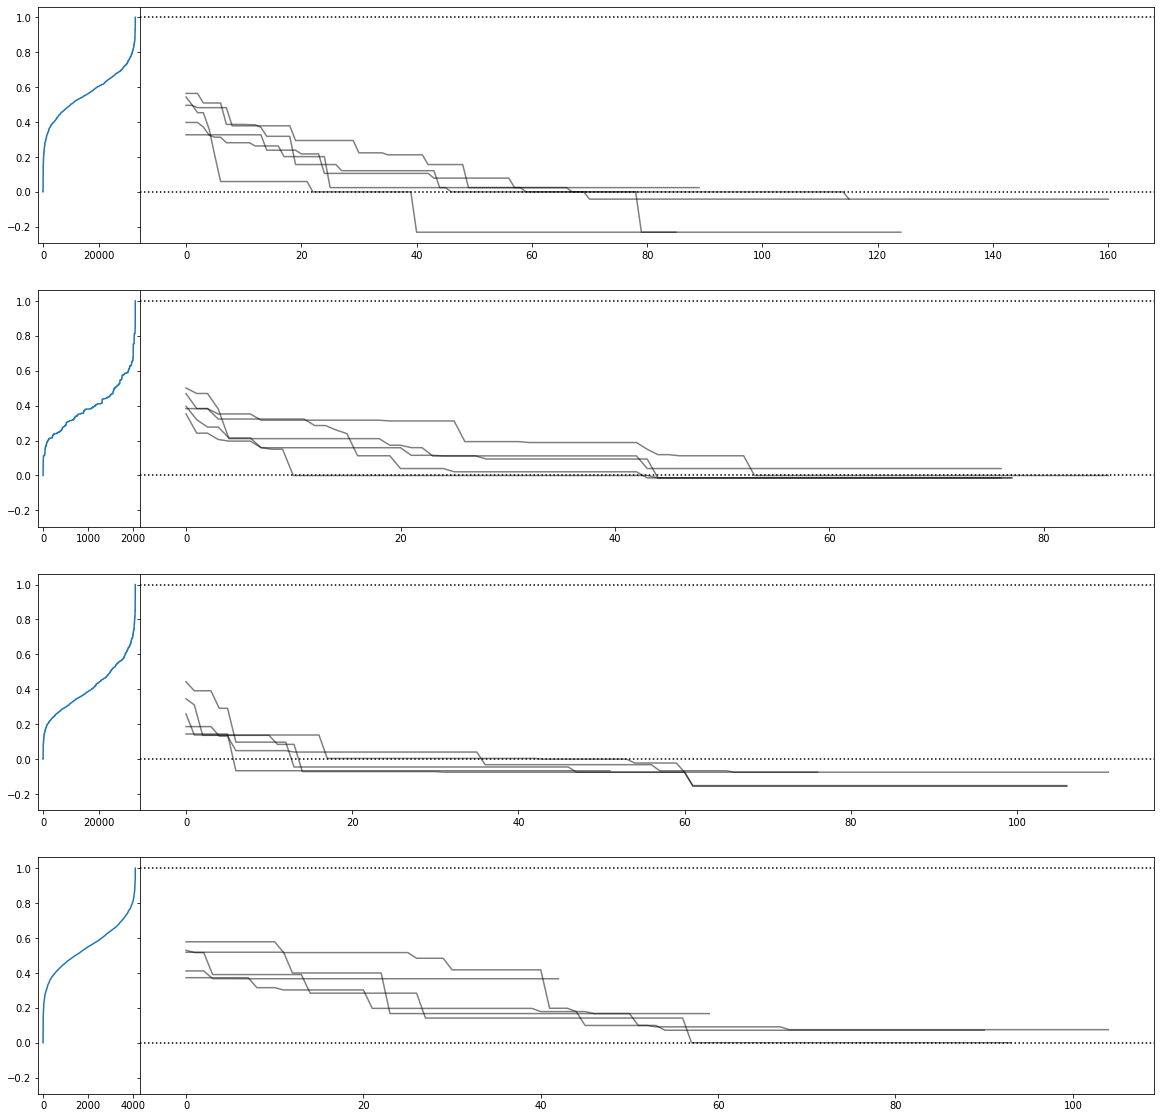

In [64]:
fig, axes = plt.subplots(ncols = 1, nrows = 1, figsize = (12,4))

def compute_phase_diagram(sampling_points, function, extra_args, n_jobs = 6):

    t0 = time()
    with WorkerPool(n_jobs = n_jobs, shared_objects = extra_args) as pool: 
        data = pool.map(computation, sampling_points, progress_bar = True).T
    dt = time() - t0
    print(f'That tooks {dt:.2f} seconds or {dt/len(sampling_points)*1000*n_jobs:.0f}ms per sample point')

    return data

def descent_gs_finder(lattice, starting_ujk = 'random', njobs = 10)

    def worker(lattice, hamiltonian, starting_ujk, max_iterations = 5000, move_function)
        if starting_ujk == 'random': ujk = np.random.choice([-1,1], size = lattice.n_edges)
        else if starting_ujk == '+1': ujk = np.ones(lattice.n_edges)
        out_ujk, energies = descent(lattice, hamiltonian, ujk, max_iterations = 5000, move_function = random_plaquette_pair)
    
    print(f"Starting descent with {n_jobs} parallel procesess.")
    def computation(extra_args, ids): return np.array([function(**extra_args) for id in ids])

        
        hamiltonian = construct_Ajk(lattice, colourings[n], ujk, J_vals)
        
        ax2.plot((energies - gs) / bandwidth, color = color, alpha = 0.5)
        out_ujks[n].append([energies[-1], out_ujk])